<a href="https://colab.research.google.com/github/MSaber9/Machine-Learning/blob/master/BayesianNetworkv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Network

Explore existing file formats for representing Bayesian networks. Choose any of the formats you like. You can use the existing parsers for networks of the selected file format.

Implement two Bayesian probability inference algorithms, which will answers to requests for any subset of variables. For example of the form P(A = ai & B = bj & D = dk), note that C is missing. The first algorithm should calculate the exact answer. The second algorithm should use random sampling to calculate the required probability.

For several queries, calculate the probability using both algorithms. For the second algorithm plot dependence of current probability on number sampled instances.

Datasets can be taken from http://www.bnlearn.com/bnrepository/ or http://www.cs.huji.ac.il/~galel/Repository/

## Library

In [2]:
! pip install pgmpy

     |████████████████████████████████| 348kB 8.4MB/s 


In [0]:
import numpy as np
import os
import copy
from pgmpy import readwrite
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
import matplotlib.pyplot as plt
from pgmpy.inference import VariableElimination
from collections import defaultdict
from functools import reduce

## Load Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
!ls 'drive/My Drive/Colab Notebooks/Data/'

 001.jpg    cancer.bif	     gist_vehicleimg.npy      vehicleimg
 01.jpg     DataImg	     gist_vehicletrgt.npy     vehicletrgt
 02.jpg     DataLab5	     HumanDog
 asia.bif   earthquake.bif   keras-retinanet-master
 CamVid     g01.jpg	    ' Natural Scenes '


In [0]:
#bnfile = readwrite.BIF.BIFReader("/content/earthquake.bif")

In [0]:
path = 'drive/My Drive/Colab Notebooks/Data/earthquake.bif'
bnfile  = readwrite.BIF.BIFReader(path)

# Bayesian Network - Exact Inference

## Get Info : 

#### Var - Prob - Model - CPD - Ex Infer

In [0]:
variables = bnfile.get_variables()
probability = bnfile.get_probability_grammar()

In [0]:
model = bnfile.get_model()

P(b,e,a,j,m) = P(b) * P(e) * P(A|b,e) * P(j|a) * P(m|a)

In [10]:
cpd_burglary = model.get_cpds('Burglary')
cpd_earthquake =model.get_cpds('Earthquake')
cpd_alarm = model.get_cpds('Alarm')
cpd_johncalls = model.get_cpds('JohnCalls')
cpd_marycalls = model.get_cpds('MaryCalls')


print (cpd_burglary)
print (cpd_earthquake)
print (cpd_alarm)
print (cpd_johncalls)
print (cpd_marycalls)

+-----------------+------+
| Burglary(True)  | 0.01 |
+-----------------+------+
| Burglary(False) | 0.99 |
+-----------------+------+
+-------------------+------+
| Earthquake(True)  | 0.02 |
+-------------------+------+
| Earthquake(False) | 0.98 |
+-------------------+------+
+--------------+------------------+-------------------+------------------+-------------------+
| Burglary     | Burglary(True)   | Burglary(True)    | Burglary(False)  | Burglary(False)   |
+--------------+------------------+-------------------+------------------+-------------------+
| Earthquake   | Earthquake(True) | Earthquake(False) | Earthquake(True) | Earthquake(False) |
+--------------+------------------+-------------------+------------------+-------------------+
| Alarm(True)  | 0.95             | 0.94              | 0.29             | 0.001             |
+--------------+------------------+-------------------+------------------+-------------------+
| Alarm(False) | 0.05             | 0.06              |

Variable elimination (VE): Exact Inference with VariableEliminatin using pgmpy query




Variable elimination (VE) is a simple and general exact inference algorithm in 
- probabilistic graphical models (e.g. Bayesian networks - Markov random fields).

It can be used for:
- Inference of maximum a posteriori (MAP) state or
- Estimation of conditional or 
- Marginal distributions over a subset of variables. 

VE: Called sum-out, or marginalization, eliminates a single variable from a set of factors and returns the resulting set of factors - The algorithm collect-relevant simply returns those factors in involving variable.




In [0]:
ex1_infer = VariableElimination(model)

In [14]:
q1 = ex1_infer.query(['Alarm'], {'Burglary': "True", 'Earthquake':"True" })

Eliminating: MaryCalls: 100%|██████████| 2/2 [00:00<00:00, 294.98it/s]


In [15]:
print(q1)

+--------------+--------------+
| Alarm        |   phi(Alarm) |
+==============+==============+
| Alarm(True)  |       0.9500 |
+--------------+--------------+
| Alarm(False) |       0.0500 |
+--------------+--------------+


## Function - Joint Probability Product :

- JPP (Model, Var, Type ) > P




In [0]:
# Variable Elimination Algorithm to calculate the exact probability

varis = ['Burglary','Earthquake','JohnCalls'] # input
# 'Burglary':1,'Earthquake':1,'JohnCalls':1
vari_type = {'Burglary':1,'Earthquake':1,'JohnCalls':1}

def joint_prob_product(model = model,varis = varis,vari_type = vari_type):
    all_nodes = model.nodes()
    factors = defaultdict(list)
    all_unique_factors = set()

    # Get > CPD > Factor
    for node in all_nodes:
        cpd = model.get_cpds(node)
        cpd = cpd.to_factor()
        for var in cpd.scope(): 
            factors[var].append(cpd)

    # Get > Factor > Unique Factor
    for node in all_nodes:    
        for factor in factors[node]:
            if not {factor}.intersection(all_unique_factors):
                all_unique_factors.add(factor)

    # Prod Dist. > Type Var. + PD Value / Tem Value > Joint P
    product_distribution = reduce(lambda dist1, dist2: dist1 * dist2, all_unique_factors)
    pd_values = product_distribution.values

# ------------- type_var--------------------------------------------------------------
    for i in range(len(product_distribution.variables)):
        var = product_distribution.variables[i]

        if var in vari_type.keys():
            type_var =  vari_type[var]                # Type Var
            pd_values = pd_values[type_var]           # PD Value

        else:

            tem_values = np.zeros(pd_values[0].shape) # Tem Value
            for j in range(product_distribution.get_cardinality([var])[var]):
                tem_values += pd_values[j]
            pd_values = tem_values

    Joint_p = pd_values
    return Joint_p

In [52]:
P = joint_prob_product()
print(P)

0.9208653299999999


## Function - Joint Probability Product : (Factor)

JPP (Model - Var) > Product Dist - Joint Factor

In [0]:
def joint_factor_calc(model=model):
  varis = ['Burglary','Earthquake','JohnCalls']
  all_nodes = model.nodes()
  factors = defaultdict(list)
  all_unique_factors = set()

  # Get > CPD > Factor
  for node in all_nodes:
    cpd = model.get_cpds(node)
    cpd = cpd.to_factor()
    for var in cpd.scope():
      factors[var].append(cpd)

  # Get > Factor > Unique Factor
      for node in all_nodes:
        for factor in factors[node]:
          if not {factor}.intersection(all_unique_factors):
            all_unique_factors.add(factor)

  # Prod Dist. > Type Var. + PD Value > Joint Factor
  product_distribution = reduce(lambda dist1, dist2: dist1 * dist2, all_unique_factors)
  joint_factor = product_distribution.marginalize(list(set(all_nodes) - set(varis)), inplace=False)

  return joint_factor 
#print(product_distribution)        

In [55]:
vari_type = [1,1,1]
j_f = joint_factor_calc()
print(j_f)
print(j_f.values[vari_type[0]][vari_type[1]][vari_type[2]])
# 'Burglary','Earthquake','JohnCalls'

+-----------------+-------------------+------------------+--------------------------------------+
| Burglary        | Earthquake        | JohnCalls        |   phi(Burglary,Earthquake,JohnCalls) |
+=================+===================+==================+======================================+
| Burglary(True)  | Earthquake(True)  | JohnCalls(True)  |                               0.0002 |
+-----------------+-------------------+------------------+--------------------------------------+
| Burglary(True)  | Earthquake(True)  | JohnCalls(False) |                               0.0000 |
+-----------------+-------------------+------------------+--------------------------------------+
| Burglary(True)  | Earthquake(False) | JohnCalls(True)  |                               0.0083 |
+-----------------+-------------------+------------------+--------------------------------------+
| Burglary(True)  | Earthquake(False) | JohnCalls(False) |                               0.0015 |
+-----------------+-

## Function - Joint Probability Distribution :

JPD (Var, Model) > P

In [0]:
def joint_prob_distribution(model = model):
  # 'Burglary':1,'Earthquake':1,'JohnCalls':1
  varis = {'Burglary':"True",'Earthquake':"True",'JohnCalls':"True"}
  varis_list = list(varis.keys())
  print(varis_list)

  for i in range(len(varis_list)): 
    print('The variable which gonna calculate probability:',varis_list[i])
    tem_cpd = model.get_cpds(varis_list[i])
    tem_dict = {}
    tem_vari = copy.deepcopy(varis_list) # copy
    tem_vari.remove(varis_list[i])

    for k in range(len(tem_vari)): # tem_vari=varis
      if tem_vari[k] in tem_dict.keys():
        print("nope")
      else:
        tem_dict.update({tem_vari[k]:varis[tem_vari[k]]})

      ex_infer = VariableElimination(model)
      prob = ex_infer.query(variables= [varis_list[i]],evidence= tem_dict)
      P =  1 * prob.values[0]
  return P

In [64]:
p = joint_prob_distribution()
p

Eliminating: Alarm: 100%|██████████| 2/2 [00:00<00:00, 503.76it/s]

['Burglary', 'Earthquake', 'JohnCalls']
The variable which gonna calculate probability: Burglary
The variable which gonna calculate probability: Earthquake
The variable which gonna calculate probability: JohnCalls


0.8574999999999999

# Bayesian Network - Sampling

Model > Temp CPD > Value , Card , Parent > Sample (Card,Value)

In [0]:
def sampling(model = model, num_sample = 10):
    sample_dict = {}
    num = 0

    while num < num_sample:
        num += 1
        samples = []

        for vari in variables:
            tem_cpd = model.get_cpds(vari)
            vari_value = tem_cpd.values
            card = tem_cpd.variable_card
            parents = tem_cpd.variables[1:]

            if parents:

                # Parent
                parents_card = []
                for parent in parents:
                    tem_index = variables.index(parent)
                    parents_card.append(samples[tem_index])
                #print('all_values',vari_value)

                # Value
                tem_value = []
                for l in range(vari_value.shape[0]):
                    anyway = vari_value[l]
                    for k in parents_card:
                        anyway = anyway[k]
                        #print('step value:',anyway)
                    tem_value.append(anyway)

                # Sample (Card, Value)    
                # print('probability:',tem_value)
                tem_sample = np.random.choice(card,1,p=tem_value)
                samples.append(tem_sample[0]) # Samples[Tem value] OR

            else:

                tem_sample = np.random.choice(card,1,p=vari_value)
                samples.append(tem_sample[0]) # Samples [var value]

            tup_samples = tuple(samples)
        
        if tup_samples in sample_dict.keys():
            sample_dict[tup_samples] += 1
        else:
            sample_dict.update({tup_samples:1})
    return sample_dict
    

In [23]:
all_dict = sampling(num_sample = 10000)
all_dict

{(0, 0, 0, 0, 0): 2,
 (0, 0, 0, 0, 1): 1,
 (0, 1, 0, 0, 0): 40,
 (0, 1, 0, 0, 1): 39,
 (0, 1, 0, 1, 0): 4,
 (0, 1, 0, 1, 1): 5,
 (0, 1, 1, 1, 1): 7,
 (1, 0, 0, 0, 0): 24,
 (1, 0, 0, 0, 1): 20,
 (1, 0, 0, 1, 0): 6,
 (1, 0, 0, 1, 1): 1,
 (1, 0, 1, 0, 1): 13,
 (1, 0, 1, 1, 0): 1,
 (1, 0, 1, 1, 1): 120,
 (1, 1, 0, 0, 0): 5,
 (1, 1, 0, 0, 1): 4,
 (1, 1, 0, 1, 0): 1,
 (1, 1, 0, 1, 1): 1,
 (1, 1, 1, 0, 0): 5,
 (1, 1, 1, 0, 1): 457,
 (1, 1, 1, 1, 0): 91,
 (1, 1, 1, 1, 1): 9153}

In [24]:
variables

['Burglary', 'Earthquake', 'Alarm', 'JohnCalls', 'MaryCalls']

In [26]:
dic = {'Burglary':0,'Earthquake':0,'Alarm':0}
index = []
for vari in dic.keys():
    index.append(variables.index(vari))
print(index)

# ['Burglary', 'Earthquake', 'Alarm', 'JohnCalls', 'MaryCalls']
# [ 0 , 1 , 2 , 3 , 4 ]

[0, 1, 2]


In [0]:
def count_P(varis = variables, all_dic = all_dict,sample_dict = dic,num_sample = 10):
    count = 0
    for sample in all_dict.keys():
        #sample = (1, 0, 0, 0, 0)
        tem_dict = {}

        for i in range(len(varis)):
            if varis[i] in tem_dict.keys():
                print('wrong')
            else:
                tem_dict.update({varis[i]:sample[i]}) #Tem Dic [Var]
        if tem_dict.items() & sample_dict.items() == sample_dict.items():
            count += all_dic[sample]

    P = count/num_sample
    return P
    
#tem_dict
    

In [30]:
P_psx = count_P(num_sample = 100000)
P_psx * 10 # 0.0003

0.00030000000000000003

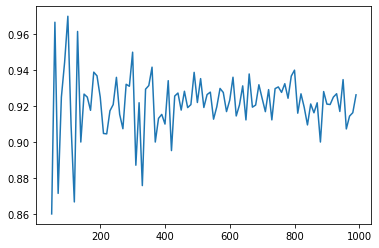

In [33]:
P_list =[]
num_epoch = 1000
X = np.arange(50,num_epoch,10)
# X = np.arange(25,1000,20)

for num in range(50,num_epoch,10):

    dic = {'Burglary':1,'Earthquake':1,'JohnCalls':1}
    all_dict = sampling(num_sample = num)
    P = count_P(all_dic=all_dict,sample_dict = dic,num_sample = num)
    P_list.append(P)


plt.figure()
plt.plot(X,P_list)
plt.show()

In [0]:
num_epoch = 100000
a = []
X = np.arange(1,num_epoch,2000)
print(len(X))

50


# Testo: Asia Data

In [0]:
asia_path = 'drive/My Drive/Colab Notebooks/Data/asia.bif'
asia = readwrite.BIF.BIFReader(asia_path)

In [0]:
variables_asia = asia.get_variables()
print(variables_asia)
asia_model = asia.get_model()

['asia', 'tub', 'smoke', 'lung', 'bronc', 'either', 'xray', 'dysp']


In [0]:
cpd_asia = asia_model.get_cpds('asia')
cpd_tub =asia_model.get_cpds('tub')
cpd_smoke = asia_model.get_cpds('smoke')
cpd_lung = asia_model.get_cpds('lung')
cpd_bronc = asia_model.get_cpds('bronc')
cpd_either = asia_model.get_cpds('either')
cpd_xray = asia_model.get_cpds('xray')
cpd_dysp = asia_model.get_cpds('dysp')

print(cpd_asia )
print(cpd_tub)
print(cpd_smoke)
print(cpd_lung)
print(cpd_bronc)
print(cpd_either)
print(cpd_xray)
print(cpd_dysp)

+-----------+------+
| asia(yes) | 0.01 |
+-----------+------+
| asia(no)  | 0.99 |
+-----------+------+
+----------+-----------+----------+
| asia     | asia(yes) | asia(no) |
+----------+-----------+----------+
| tub(yes) | 0.05      | 0.01     |
+----------+-----------+----------+
| tub(no)  | 0.95      | 0.99     |
+----------+-----------+----------+
+------------+-----+
| smoke(yes) | 0.5 |
+------------+-----+
| smoke(no)  | 0.5 |
+------------+-----+
+-----------+------------+-----------+
| smoke     | smoke(yes) | smoke(no) |
+-----------+------------+-----------+
| lung(yes) | 0.1        | 0.01      |
+-----------+------------+-----------+
| lung(no)  | 0.9        | 0.99      |
+-----------+------------+-----------+
+------------+------------+-----------+
| smoke      | smoke(yes) | smoke(no) |
+------------+------------+-----------+
| bronc(yes) | 0.6        | 0.3       |
+------------+------------+-----------+
| bronc(no)  | 0.4        | 0.7       |
+------------+-----------